In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot
import Optim

In [2]:

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

In [3]:
#folder = "/home/data/simon/processed/143_houston_summer2017/river" #desend
#folder = "/home/data/simon/processed/143_houston_summer2017/city_center" #desend
folder = "/home/data/simon/processed/143_houston_summer2017/resovoir" #desend
#folder = "/home/data/simon/processed/66_fyn_winter2020/kolding" #desend
#folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" #desend
#folder = "/home/data/simon/processed/177_jutlandS_autumn2019/vejle" # asend
#folder = "/home/data/simon/processed/177_jutlandS_winter2020/vejle" # asend
#folder = "/home/data/simon/processed/177_jutlandS_winter2020/ribe" # asend


ascending = false
#dem_nan = 40
dem_nan=-25

-25

In [4]:
cd("/home/data/simon/result/HSBA")

In [5]:

result_folder = "/home/data/simon/result/HSBA"
cd(result_folder)
temp ,folder1 =  splitdir(folder)
temp ,folder2=  splitdir(temp)
mkpath(joinpath(folder2,folder1)) 
result_folder = joinpath(result_folder,joinpath(folder2,folder1))

"/home/data/simon/result/HSBA/143_houston_summer2017/resovoir"

In [6]:
if ascending 
   # Load
    co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[end:-1:1,:]
    pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[end:-1:1,:]

    VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
    VV = [JLD.load(path,"data")[end:-1:1,:] for path in VV_paths]
    VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
    VH = [JLD.load(path,"data")[end:-1:1,:] for path in VH_paths];
    heights = JLD.load(joinpath(folder,"heights.jld"),"data")[end:-1:1,:].-dem_nan;
else
    # Load
    co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[:,end:-1:1]
    pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[:,end:-1:1]

    VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
    VV = [JLD.load(path,"data")[:,end:-1:1] for path in VV_paths]
    VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
    VH = [JLD.load(path,"data")[:,end:-1:1] for path in VH_paths];
    heights = JLD.load(joinpath(folder,"heights.jld"),"data")[:,end:-1:1].-dem_nan;
    end;

In [7]:
filt = SlcUtil.temporal_filter([VV[1],VH[1]],5);

VV = SlcUtil.temporal_filter(VV,5);
VH = SlcUtil.temporal_filter(VH,5);

VV[1] = filt[1]
VH[1] = filt[2];

In [43]:
pol = "VH"
ref = 2
test_area =0 # (1:size(VV[1],1),500:size(VV[1],2))
subset = ""


ref_band = 0
min_pol = 0
max_pol = 0
bands = 0
if pol == "VV";
    bands = VV
    min_pol = min_vv
    max_pol = max_vv
elseif pol == "VH"
    bands = VH
    min_pol = min_vh
    max_pol = max_vh
end

flood_band = 10 .*log10.(bands[1]);

if ref == 0
    ref_band = 10 .*log10.((bands[2].+bands[3])./2);
else
    ref_band = 10 .*log10.(bands[ref]);
end;

if length(test_area) == 2
    ref_band = ref_band[test_area...]
    flood_band = flood_band[test_area...]
    bands = [elem[test_area...] for elem in bands ]
    subset = "subset"
end

change_band = flood_band.-ref_band;

prefix_name = subset*pol

"VH"

In [44]:
img_col = pretty_img(bands,min_pol,max_pol);
img_bw = Colors.Gray.(scale_img(flood_band,min_pol,max_pol));
img_bw  = convert.(Colors.RGB{Float32},img_bw );

In [45]:

bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


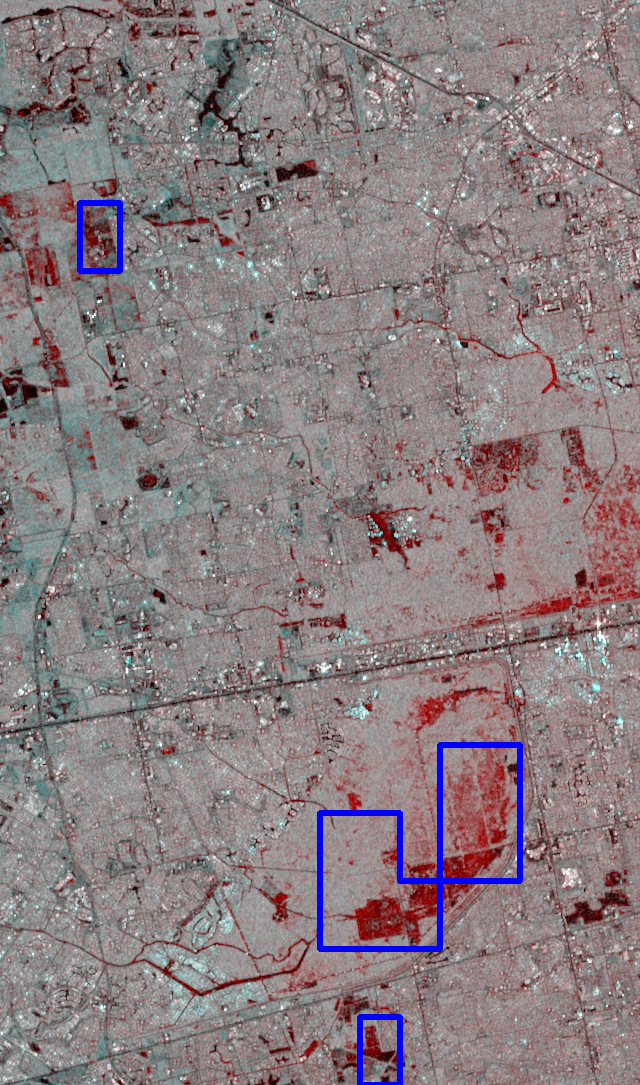

In [46]:

img_mask = add_mask(img_col, get_edges(bm_mask,2) ,(0,0,1));
file_name = prefix_name * "_tiles.png"
FileIO.save(joinpath(result_folder,file_name),img_mask)
img_mask

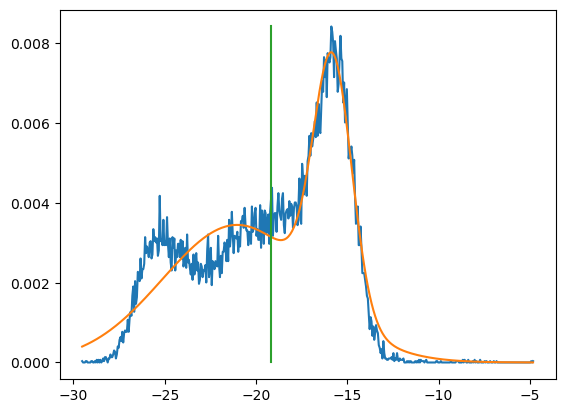

In [47]:
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed

fig = PyPlot.figure()
PyPlot.plot(y,w)
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(ones(2)*(y_seed), [0,maximum(w)])

file_name = prefix_name * "_hist_tile.png"
fig.savefig(joinpath(result_folder,file_name), dpi=100)

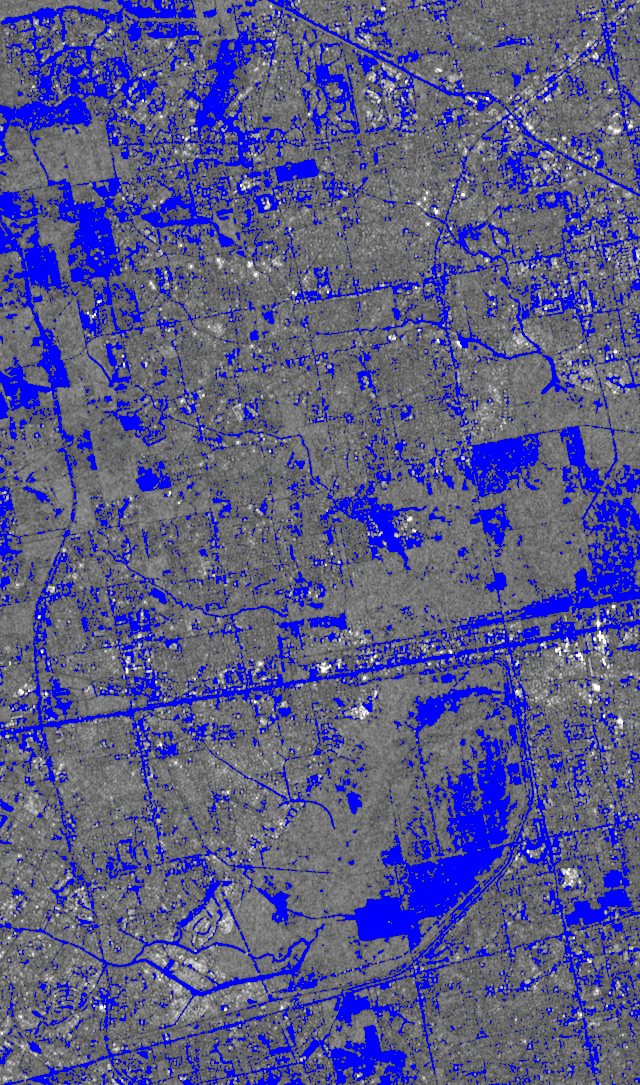

In [48]:
img_mask = add_mask(img_bw, seed_mask ,(0,0,1))
file_name = prefix_name * "_seed.png"
FileIO.save(joinpath(result_folder,file_name),img_mask)
img_mask

In [49]:
t_0 = [y_seed+1, -1]

res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)

# use optimize values to find flood mask
rg_thresholds = res.minimizer
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

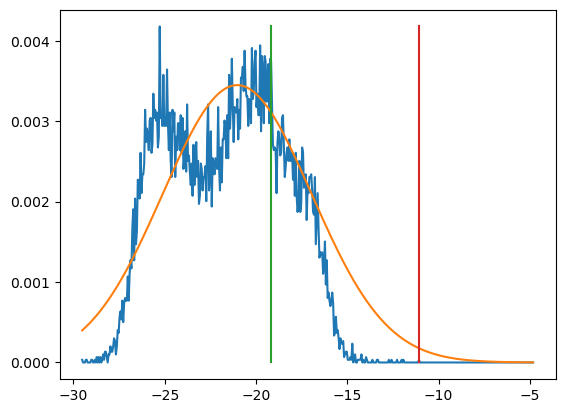

In [50]:
data = reshape(flood_band,:)[reshape(bm_mask .& flood_mask ,:)]

h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;
w_water_est = gauss_model(y,p_fit[[1,3,5]])

fig = PyPlot.figure()
PyPlot.plot(y,w_sel)
PyPlot.plot(y, w_water_est )
PyPlot.plot(ones(2)*(y_seed), [0,maximum(w_sel)])
PyPlot.plot(ones(2)*(rg_thresholds[1]), [0,maximum(w_sel)])

file_name = prefix_name * "_hist_flood.png"
fig.savefig(joinpath(result_folder,file_name), dpi=100)

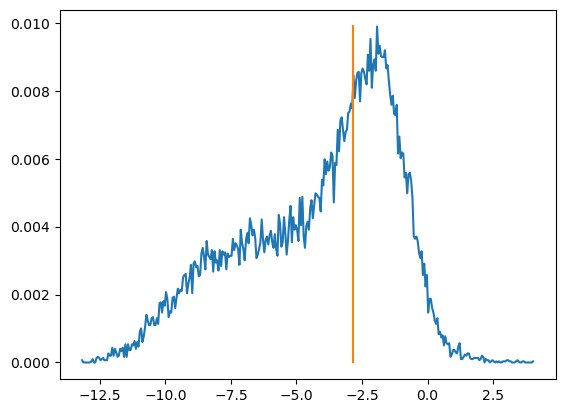

In [51]:
data = reshape(change_band,:)[reshape(bm_mask ,:)]
n_bins = round(Int64,length(data)/50)
h = StatsBase.fit(StatsBase.Histogram, data,nbins=n_bins)
w_change = h.weights./sum(h.weights);
edges_change = collect(h.edges[1])
y_change = (edges_change[2:end] +  edges_change[1:end-1])/2;

fig = PyPlot.figure()
PyPlot.plot(y_change,w_change)
PyPlot.plot(ones(2)*(rg_thresholds[2]), [0,maximum(w_change)])

file_name = prefix_name * "_hist_change_tiles.png"
fig.savefig(joinpath(result_folder,file_name), dpi=100)

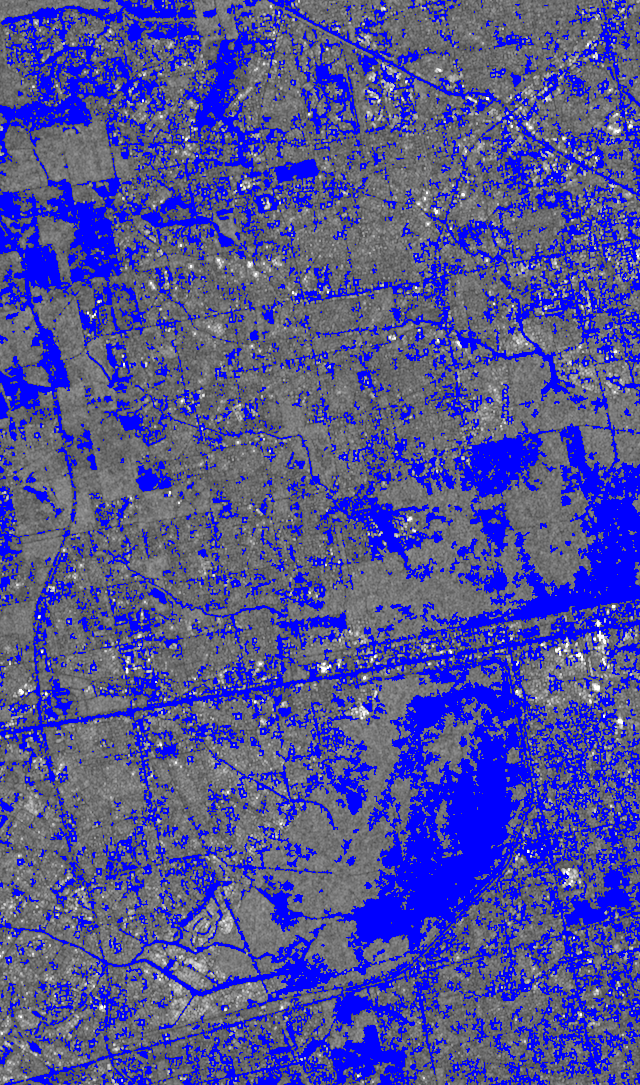

In [52]:
img_mask = add_mask(img_bw, flood_mask ,(0,0,1))
file_name = prefix_name * "_flood.png"
FileIO.save(joinpath(result_folder,file_name),img_mask)
img_mask

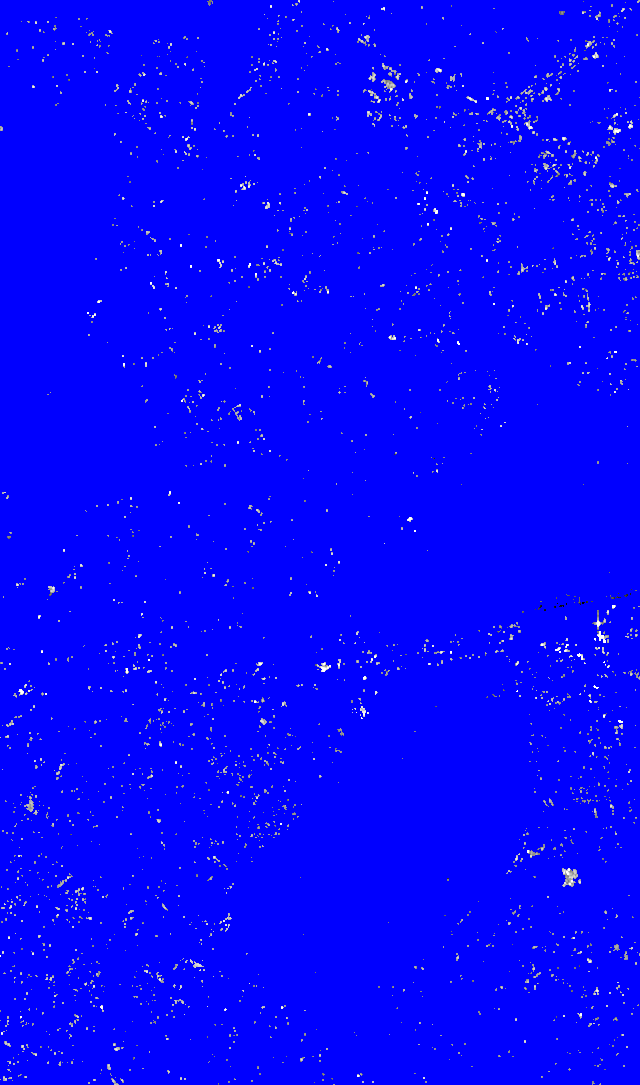

In [53]:
# Make region growing og refference image to find Permant water and false positives
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
img_mask = add_mask(img_bw, ref_mask ,(0,0,1))
file_name = prefix_name * "_ref.png"
FileIO.save(joinpath(result_folder,file_name),img_mask)
img_mask

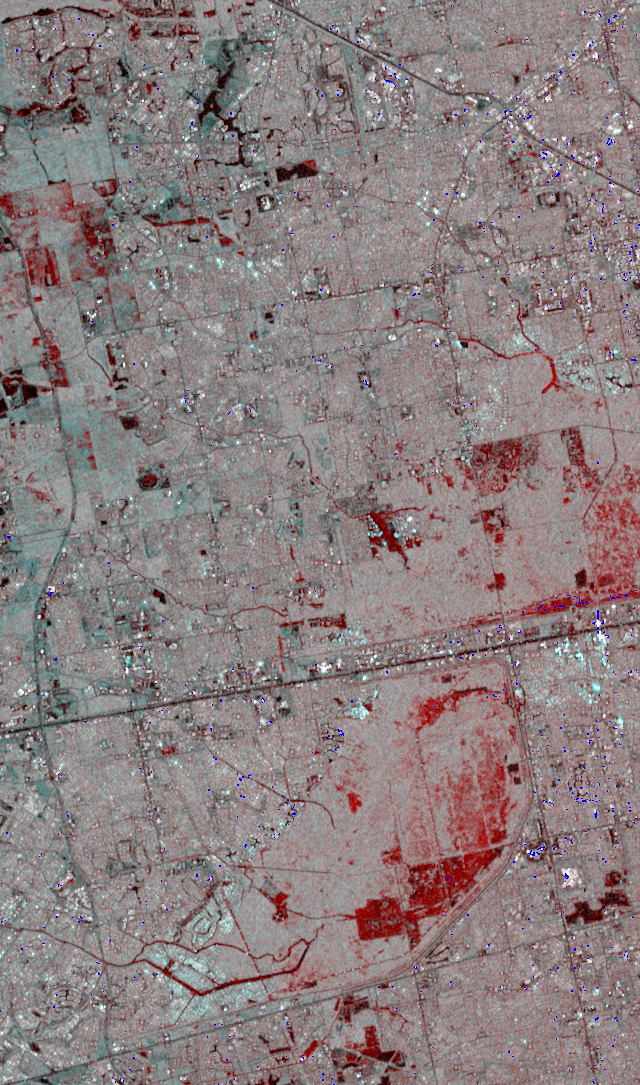

In [54]:
final_mask = flood_mask .& (ref_mask .!=true);
img_mask = add_mask(img_col, final_mask ,(0,0,1))
file_name = prefix_name * "_final.png"
FileIO.save(joinpath(result_folder,file_name),img_mask)
img_mask

In [1]:
dir_path = "/home/data/simon/result/HSBA/143_houston_summer2017/resovoir"
dir_path*(".zip")

"/home/data/simon/result/HSBA/143_houston_summer2017/resovoir.zip"

In [2]:
 run(`zip -q -j -r $(dir_path*(".zip")) $dir_path`)# zip files

Process(`zip -q -j -r /home/data/simon/result/HSBA/143_houston_summer2017/resovoir.zip /home/data/simon/result/HSBA/143_houston_summer2017/resovoir`, ProcessExited(0))